In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, MLSolver

Precompiling packages...
  11796.1 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 14 seconds. 474 already precompiled.


In [2]:
using CairoMakie, ProgressLogging

## Basic no space solve

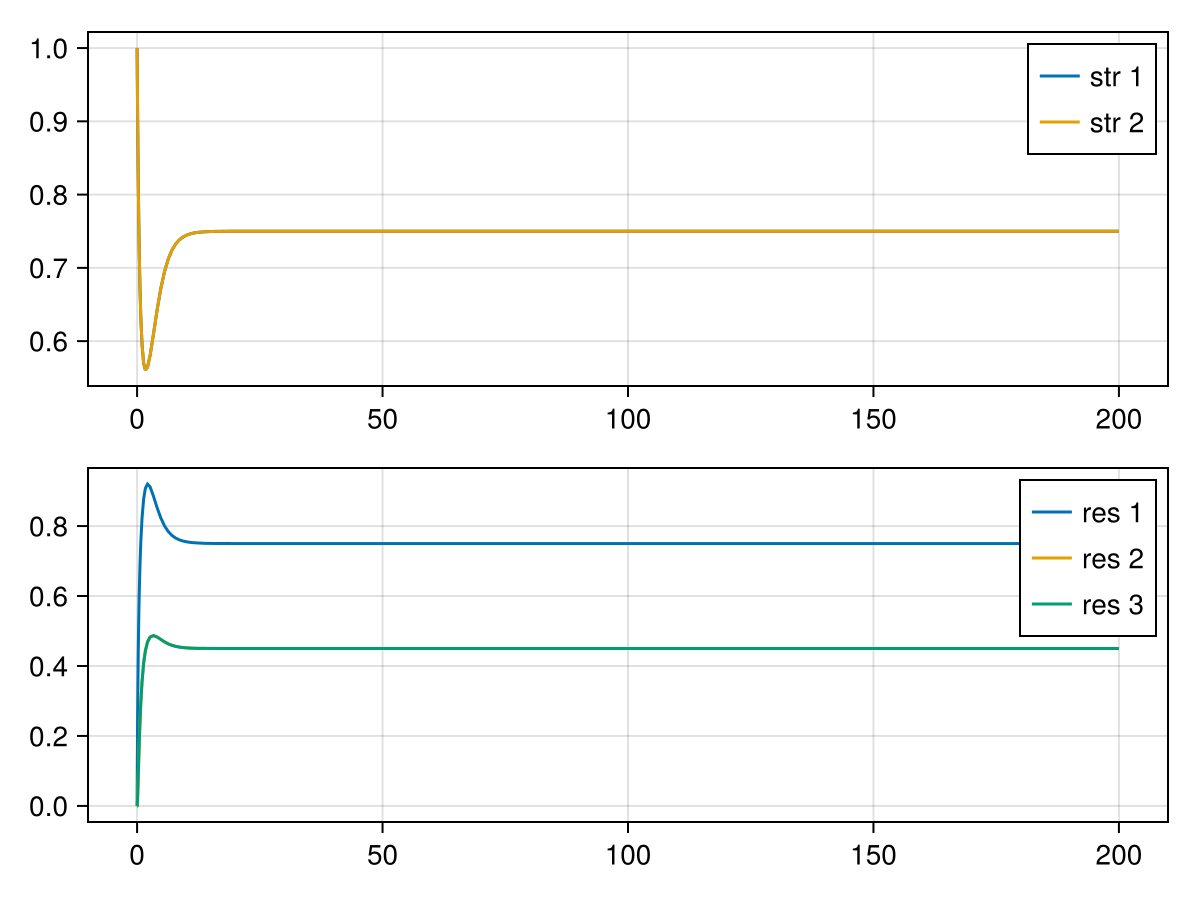

CairoMakie.Screen{IMAGE}


In [108]:
D = fill(0., 2, 3, 3)
D[1,:,:] .= [0. 0. 0.; 0. 0. 0.; 1 0. 0.]
D[2,:,:] .= [0. 0. 0.; 1. 0. 0.; 0. 0. 0.]
p = make_mmicrm_smart(2, 3, 200;
    D=SArray{Tuple{2,3,3}}(D),
    K=[3., 0., 0.],
    r=[1., 1., 1.],
    l=[1. 0. 0.; 1. 0. 0.],
    c=[2. 2. 0.; 2. 0. 2.],
    m=[0.9, 0.9],
    u0=[1., 1., 0., 0., 0.],
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
# display(p.p.c)
# display(p.p.D[1,:,:])
# display(p.p.D[2,:,:])
#show(s.u[end])
# param_summary(p.p)

## Linear stability analysis

In [109]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.75, u2 => 0.75, u3 => 0.75, u4 => 0.45, u5 => 0.45]
 [u1 => 0.16666666666666666, u2 => 0.16666666666666666, u3 => 1.8, u4 => 0.45, u5 => 0.45]
 [u1 => 0.0, u2 => 0.0, u3 => 3.0, u4 => 0.0, u5 => 0.0]

In [110]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[0.7499991588608942, 0.7499991588608942, 0.7500007386390256, 0.4500002918297526, 0.4500002918297526]

In [111]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 0.01, 1e2, 1., 1.]
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(sssol.u, p.p, 0))

[4.3774413793952167e-7, 4.3774413793952167e-7, -4.311362995501611e-7, -1.2630005818969892e-7, -1.2630005818969892e-7]

maximum(real(lambdas)) = 0.23503411881277064


[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410
[ Info: we are getting non-zero imaginary parts, max(abs(.)) is 1.427410


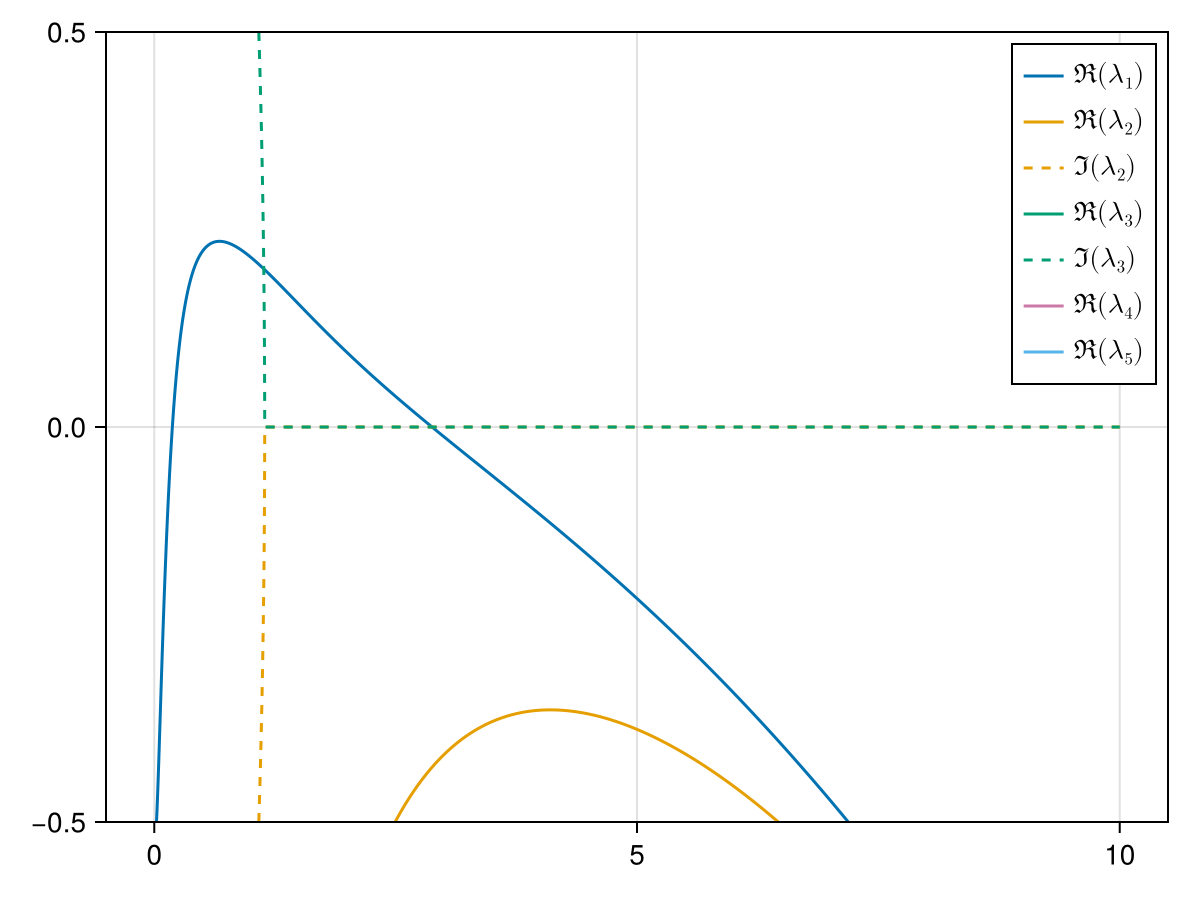

In [112]:
lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.5, 0.5))
#xlims!(faa.axis, (0., 2.))
faa

In [113]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(676, 0.6750675067506751)

In [114]:
kmax_es = ff(kmax);
kmax_es.vectors[:,1]

5-element Vector{ComplexF64}:
   0.6976388793421477 + 0.0im
   0.6976388793421481 + 0.0im
 -0.04202082925366469 + 0.0im
   0.1114321272553347 + 0.0im
  0.11143212725533479 + 0.0im

## Spatial stuff - 1D!

In [5]:
using SSMCMain.SpaceMMiCRM

In [209]:
ssize = (200,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.2, 0.2)

5×200 Matrix{Float64}:
 0.873685  0.841667  0.887707  0.858703  …  0.838146  0.887383  0.790026
 0.825981  0.906515  0.819817  0.88119      0.932438  0.896819  0.802586
 0.90165   0.902566  0.770041  0.76916      0.912145  0.825167  0.801166
 0.507975  0.590071  0.575321  0.466501     0.620927  0.639274  0.534188
 0.496166  0.616931  0.528999  0.539587     0.595319  0.557656  0.611643

In [245]:
space = make_cartesianspace_smart(length(ssize); dx=0.1)
sp = make_smmicrm_problem_safe(psu0, 10000, p.p, SA[Ds...], space)

ODEProblem with uType Matrix{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 10000.0)
u0: 5×200 Matrix{Float64}:
 0.873685  0.841667  0.887707  0.858703  …  0.838146  0.887383  0.790026
 0.825981  0.906515  0.819817  0.88119      0.932438  0.896819  0.802586
 0.90165   0.902566  0.770041  0.76916      0.912145  0.825167  0.801166
 0.507975  0.590071  0.575321  0.466501     0.620927  0.639274  0.534188
 0.496166  0.616931  0.528999  0.539587     0.595319  0.557656  0.611643

  3.621960 seconds (135.73 M allocations: 2.867 GiB, 4.76% gc time)


ReturnCode.Success = 1

8929

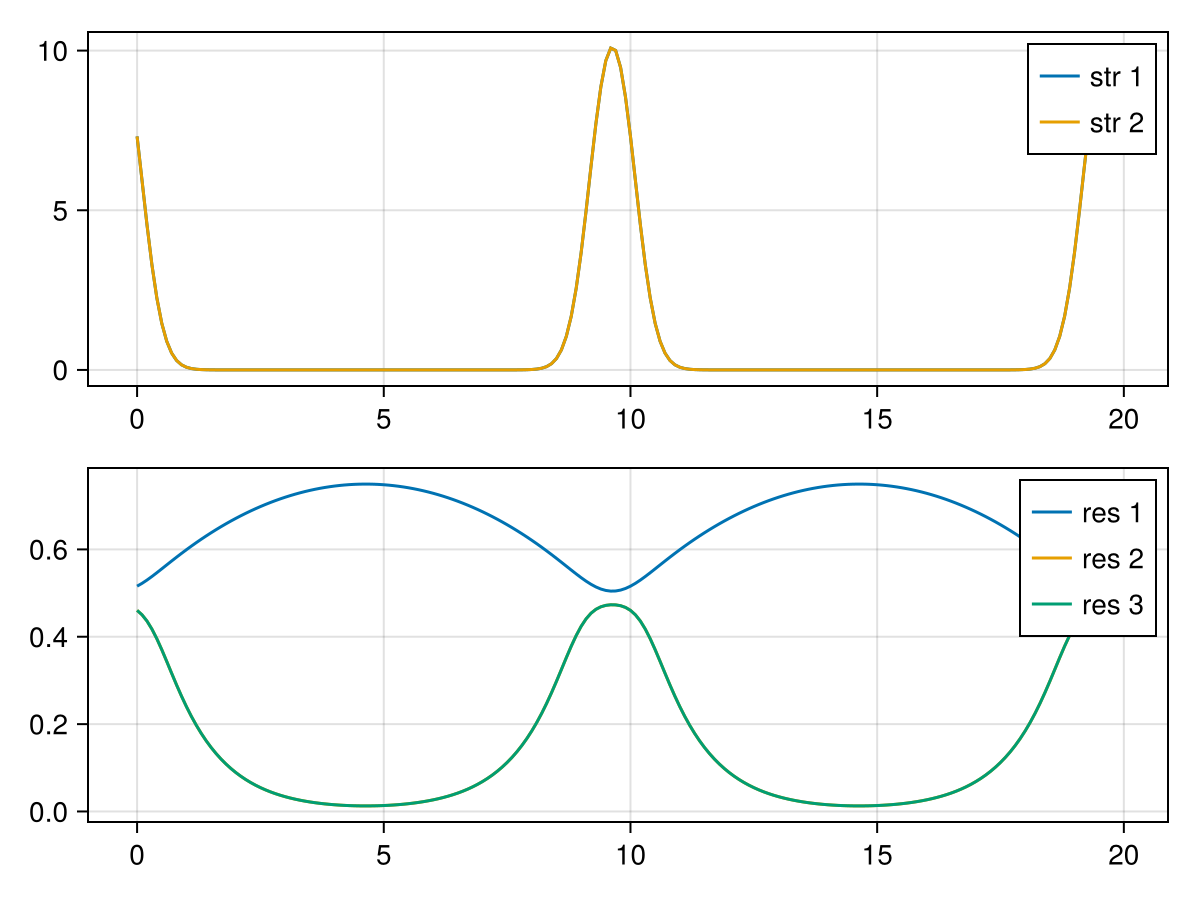

In [250]:
@time sps = solve(sp, TRBDF2())
display(sps.retcode)
display(sps.destats.nf)
plot_1dsmmicrm_sol_snap(sps, sps.t[end])

In [251]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  8929
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    97
Number of linear solves:                           1065
Number of Jacobians created:                       8
Number of nonlinear solver iterations:             875
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          122
Number of rejected steps:                          17

#### Benchmarking the smmicrmfunc!

In [285]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.2, 0.2)
space = make_cartesianspace_smart(length(ssize); dx=0.1)
sp = make_smmicrm_problem_safe(psu0, 10000, p.p, SA[Ds...], space);
size(sp.u0)

(5, 1000)

In [299]:
du = similar(sp.u0)
du .= 0
@time sp.f(du, sp.u0, sp.p)
@benchmark sp.f(du, sp.u0, sp.p)

  0.210818 seconds (327.58 k allocations: 18.731 MiB, 1009.91% compilation time)


BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  194.881 μs … 226.653 ms  ┊ GC (min … max):  0.00% … 99.76%
 Time  (median):     262.502 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   466.903 μs ±   5.311 ms  ┊ GC (mean ± σ):  27.69% ±  2.44%

  ▇█▆▄▂▂▂▂▂▁▁                                                   ▂
  ██████████████▇▇▆▆▅▅▆▆▅▅▄▄▁▁▁▄▁▄▁▁▁▄▁▁▁▄▄▃▁▃▃▃▄▃▄▄▄▄▅▃▄▃▄▅▅▄▅ █
  195 μs        Histogram: log(frequency) by time       2.73 ms <

 Memory estimate: 1.49 MiB, allocs estimate: 76184.

In [298]:
du = similar(sp.u0)
du .= 0
@time sp.f(du, sp.u0, sp.p)
@benchmark sp.f(du, sp.u0, sp.p)

  0.107389 seconds (268.91 k allocations: 14.688 MiB, 98.84% compilation time)


BenchmarkTools.Trial: 3032 samples with 1 evaluation per sample.
 Range (min … max):  1.110 ms … 17.062 ms  ┊ GC (min … max): 0.00% … 88.78%
 Time  (median):     1.616 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.646 ms ±  1.272 ms  ┊ GC (mean ± σ):  6.98% ±  8.18%

          ▂▁▁                ▃▁█▂                             
  ▁▁▁▁▁▁▂▆█████▅▄▂▃▂▂▂▂▁▁▁▁▂▂█████▆▄▄▄▆▄▃▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.11 ms        Histogram: frequency by time        2.16 ms <

 Memory estimate: 1.47 MiB, allocs estimate: 76002.

In [51]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()